In [1]:
import numpy as np

import importlib
import os, sys
sys.path.append(os.path.abspath(".."))

In [2]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

## Options

A **call option** is a financial contract giving the holder the right, but not the obligation, to buy an asset at a predetermined price \(K\) (the strike price) at a specified future time $T$ (the maturity).

The payoff of a **European call option** at maturity depends on the terminal stock price \(S_T\):

$$
\text{Payoff at } T: (S_T - K)^+ = \max(S_T - K, 0)
$$

- If $S_T > K$, the option is **in the money**, and the holder profits $S_T - K$.  
- If $S_T \le K$, the option expires worthless.

<!-- Similarly, a **European put option** has payoff:

$$
\boxed{(K - S_T)^+ = \max(K - S_T, 0)}
$$ -->

The **option price today** is the discounted expected value of the payoff under the **risk-neutral measure** $\mathbb{Q}$:

$$
C(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(S_T - K)^+]%, \quad P(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(K - S_T)^+]
$$

where $\tau = T - t$.



## Heston Model

Before the implementation of the double Heston model, having a working implementation of the standard Heston model (Heston, 1993) is convenient.

In the Heston model the evolution of the stock price $S_t$ and its variance $v_t$ is defined by the following system of stochastic differential equations (under the risk neutral measure): 

$$
\begin{aligned}
d S_t &= (r-q) S_t dt + \sqrt v_t S_t d W_{1, t} \\
d v_t & = \kappa (\theta - v_t) dt + \sigma \sqrt v_t d W_{2, t},
\end{aligned}
$$
where  $W_{1,t}, W_{2,t}$ are Brownian motions, $E^{\mathbb{Q}}[dW_{1,t},dW_{2,t}]= \rho dt$ for the risk-neutral measure $\mathbb{Q}$ and

$r$: risk-free interest rate  
$q$: continuous dividend yield  
$\kappa >0$: mean reversion speed for the variance  
$\theta>0$: mean reversion level for the variance  
$\sigma > 0$: volatility of the variance  
$\rho \in [-1,1]$: correlation between $d W_{1,t}$ and $d W_{2,t}$

### Monte Carlo Simulations (Heston)

To calculate the price numerically, we use Monte Carlo simulations. In Monte Carlo pricing $S_T$ is obtained by simulating the underlying stochastic process (i.e. Heston SDE) up to maturity $N$ times, which results in $N$ stock price paths. The price is then calculated as the discounted average of the payoffs for all the paths. We use an Euler discretization for the system of SDEs.

#### Brownian Motions

In the Euler discretization we will have $dW_{1,t}$ and $dW_{2,t}$ corresponding to differences in time of the two Brownian motions. To guarantee that $dW_{1,t}$ and $dW_{2,t}$ have $\rho$ correlation as required by the model, we generate random variables $Z_1, Z_2 \sim \mathcal{N}(0,1)$, define
$$
\boxed{
\begin{aligned}
Z_V &= Z_1 \\
Z_S &= \rho Z_V + \sqrt {1-\rho^2} Z_2,
\end{aligned}
}
$$
and make
\begin{aligned}
dW_{1,t} &= \sqrt{dt} Z_S \\
dW_{2,t} &= \sqrt{dt} Z_V.
\end{aligned}

By construction, $E[Z_V]=E[Z_S]=0$ and therefore $E[Z_V Z_S]=\rho E[Z_1^2] + \sqrt{1-\rho^2} E[Z_1 Z_2]= \rho$

#### Euler Scheme (Heston)

Using Ito's lemma for the equation for the stock price yields in integral form
$$\ln S_{t+dt} = \ln S_t + \int_{t}^{t+dt} \left( r - q - \frac{1}{2} v_u \right) du + \int_{t}^{t+dt} \sqrt v_u d W_{1,u}$$.
The Euler discretization for the process $ln S_t$ is then
\begin{align}
\ln S_{t+dt} &\approx \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t (W_{1,t+dt} - W_{1,t}) \\
 & = \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t \sqrt{dt} Z_s.
\end{align}
From which we obtain
$$\boxed{S_{t+dt} = S_t \exp \left( \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt{v_t} \sqrt{dt} Z_S \right).}$$

The integral form for the SDE for $v_t$ and corresponding Euler discretization are
\begin{align}
v_{t+dt} &= v_t + \int_{t}^{t+dt} \kappa (\theta - v_u) du + \int_{t}^{t+dt} \sigma \sqrt{v_u} dW_{2,u} \\
& \approx v_t+ \kappa (\theta -v_t) dt + \sigma \sqrt{v_t} (W_{2,t+dt}-W_{2,t}),
\end{align}
which gives the following Euler discretization for the variance
$$ \boxed{v_{t+dt} = v_t + \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} \sqrt{dt} Z_V}.$$

To avoid negative variances, we adopt the full truncation scheme, i.e. $v_t$ is replaced by $v_t^+= \max(0,v_t)$.

#### Monte Carlo Price

The Monte Carlo price is calculated using
$$\boxed{ C(K) = e^{-r \tau} \frac{1}{N} \sum_{i=1}^N \max(S^{(i)}_T-K,0) }$$
where $S^{(i)}_T$ is the terminal stock price in the stock price path $i=1, \ldots, N$.

### Exact price (Heston)

The price of a call option for the Heston model is given by the formula
$$\boxed{ C(K) = S_t e^{-q \tau} P_1 - K e^{-r \tau} P_2}$$
where 
$$ \boxed{ P _j = P(\ln S_T > K) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} \Re \left[\frac{e^{-i \phi \ln K} f_j (\phi; x_t,v_t)}{i \phi}\right] d \phi }$$.  
The functions $f_1, f_2$ are characteristic functions for the logarithm of the terminal stock price, $x_T = \ln S_T$:

$$\boxed{f_j(\phi; x_t,v_t) = \exp (C_j(\tau, \phi)+D_j(\tau, \phi) v_t+i \phi x_t),}$$
where $\tau = T-t$ is the time to maturity.

The expressions for $C_j(\tau, \phi)$ and $D_j(\tau, \phi)$ are
$$
\boxed{
\begin{align}
C_j (\tau, \phi) &= (r-q) i \phi \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i \phi - d_j) \tau - 2 \ln \left( \frac{1- c_j e^{-d_j \tau}}{1-c_j} \right) \right] \\
D_j(\tau, \phi) &= \frac{b_j - \rho \sigma i \phi-d_j}{\sigma^2} \left(\frac{1-e^{-d_j \tau}}{1-c_j e^{-d_j \tau}} \right).
\end{align}
}$$
Here, we have
$$
\boxed{
\begin{align}
c_j &= \frac{b_j - \rho \sigma i \phi - d_j}{b_j - \rho \sigma i \phi + d_j} \\
b_1 & = \kappa - \rho \sigma \\
b_2 &= \kappa \\
d_j &= \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2 (2 u_j i \phi - \phi^2)} \\
u_1 &= \frac{1}{2} \\
u_2 &=- \frac{1}{2}.
\end{align}
}
$$

These formulas use the Heston trap formulation for numerical stability. We take the principal branch of the complex root and logarithm in $d_j$ and $C_j$. The integral in $P_j$ is calculated numerically using the trapezoidal rule.

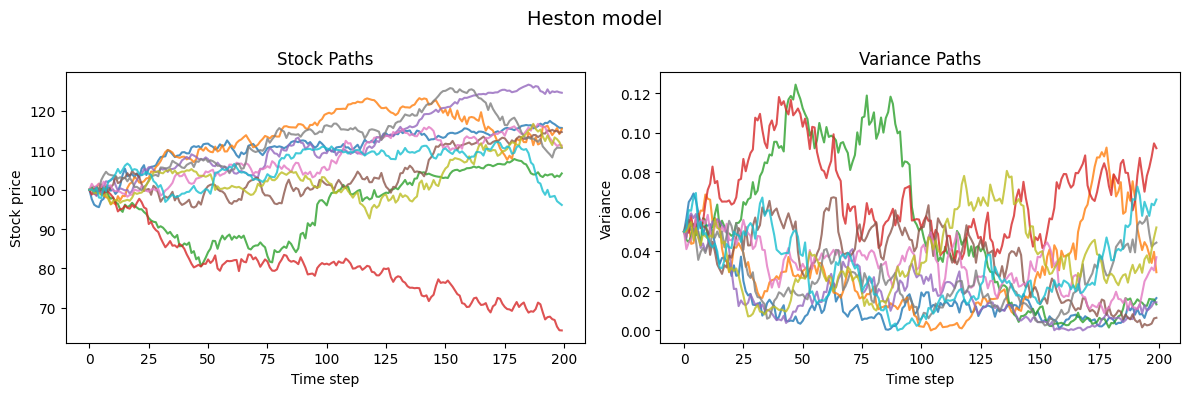

In [3]:
Heston_test_q=models.heston.Heston(r=0.03, q=0.02, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)

S_example, V_example = Heston_test_q.simulate_paths(N_paths=10,N_steps=200, 
                                                    T=0.5, S0=100, v0=0.05,seed=20)

plotting.plot_utils.plot_paths(S_example,V_example, title='Heston model')

In [4]:
Heston_test_q.mc_price(N_paths=50000, N_steps=200, 
                       K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.277166549025437)

In [5]:
Heston_test_q.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, 
                       K=100, tau=0.5, S=100, v=0.05)

np.float64(6.25281899799581)

In [6]:
# Let us compare our greeks function with cf_price
Heston_test_q.price_greeks(Lphi=0.00001, Uphi=50, dphi=0.001, 
                           K=100, tau=0.5, S=100, v=0.05)

{'call_price': np.float64(6.25281899799581),
 'delta': np.float64(0.5995065126081102)}

In [7]:
Heston_test_q.price_greeks_vect(Lphi=0.00001, Uphi=50, dphi=0.001, 
                           K=100, tau=np.array([[0.5]]), 
                                S=np.array([[100]]), v=np.array([[0.05]]))

{'call_price': array([[6.252819]]), 'delta': array([[0.59950651]])}

In [8]:
hedging_hq=utils.hedging.delta_hedge(model=Heston_test_q, model_type='heston', 
                                      K=100,N_paths=5, N_steps=200,
                                      T=0.5, S0=100, v0=0.05,seed=20)
# Warning: The simulation of the portfolio has no implementation for q!=0 yet

-0.22252711936201316 1.2809645319214638


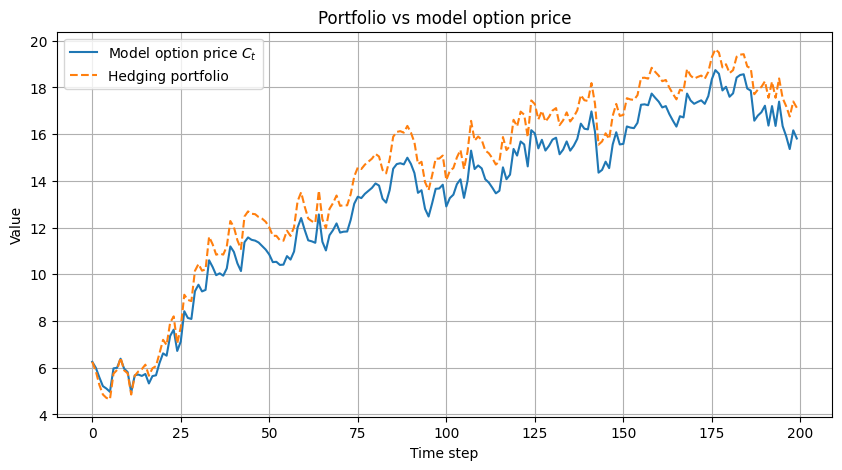

In [9]:
utils.hedging.hedge_plot(hedging_hq["opt_price"][0], hedging_hq["portfolio"][0])

In [10]:
hedging_hq["portfolio"][0], hedging_hq["cash"][0]

(array([ 6.252819  ,  5.8580556 ,  5.26570912,  4.85457773,  4.70822198,
         4.65186435,  5.74452486,  5.90373026,  6.42870019,  5.88964209,
         5.76084212,  4.85137605,  5.6533258 ,  5.8394999 ,  5.93984536,
         6.13080803,  5.65735346,  5.97466202,  6.0715972 ,  6.62171256,
         7.19439091,  6.97168508,  7.92981863,  8.19899252,  7.03893691,
         7.73738615,  9.12469463,  8.90358403,  8.85280659, 10.14556557,
        10.43997136, 10.15499839, 10.20816478, 11.60820026, 11.28416344,
        10.83812402, 10.88867115, 10.84213737, 11.19340132, 12.28094029,
        12.02303586, 11.45349969, 11.08213403, 12.47417949, 12.69265877,
        12.59151273, 12.57296662, 12.44872916, 12.37855077, 12.24666551,
        12.01274036, 11.64399266, 11.64733947, 11.45678768, 11.43715924,
        11.86628521, 11.64249649, 12.0191239 , 13.12822979, 13.51072515,
        12.90126856, 12.38912773, 12.27574841, 12.20072801, 13.58120638,
        12.35473279, 11.97136877, 12.79708906, 13.0

In [11]:
Heston_test_q0=models.heston.Heston(r=0.03, q=0.0, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)
Heston_test_q0.mc_price(N_paths=50000, N_steps=200, 
                        K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.891482806514103)

In [12]:
# Comparison with the price in Rouah's book price call = 6.8678
Heston_test_q0.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, 
                        K=100, tau=0.5, S=100, v=0.05)

np.float64(6.867834847668782)

In [13]:
hedging_hq0=utils.hedging.delta_hedge(model=Heston_test_q0, model_type='heston', 
                                      K=100,N_paths=10, N_steps=200,
                                      T=0.5, S0=100, v0=0.05,seed=5000)

0.33589349821047804 1.186497530897826


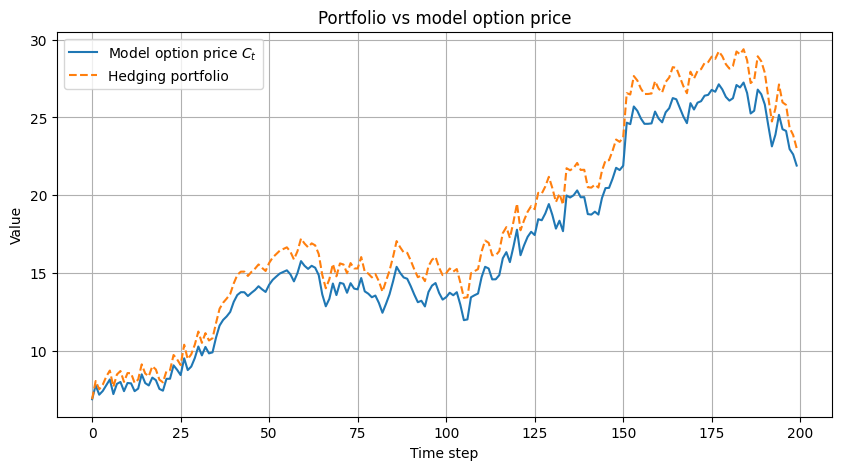

In [14]:
utils.hedging.hedge_plot(hedging_hq0["opt_price"][0], hedging_hq0["portfolio"][0])

In [15]:
hedging_hq0["portfolio"][0], hedging_hq0["cash"][0]

(array([ 6.86783485,  8.04025191,  7.50775185,  7.80049678,  8.32963384,
         8.71160752,  7.66204509,  8.45971978,  8.6823224 ,  7.98396144,
         8.55097343,  8.53922465,  7.91718008,  8.13477022,  9.11169935,
         8.51941305,  8.34241405,  8.99247887,  8.78261732,  8.12562634,
         7.95354427,  8.67972484,  8.74134652,  9.71387946,  9.43660665,
         9.06599136, 10.37565119,  9.44914275,  9.75787358, 10.3780698 ,
        11.22270856, 10.4954323 , 11.11961391, 10.64747367, 10.79005948,
        11.77235813, 12.69068408, 13.07861784, 13.34402598, 13.6419728 ,
        14.32193008, 14.86273306, 15.07714685, 15.07919133, 14.79995837,
        15.06394923, 15.26887749, 15.54119472, 15.31930677, 15.12181523,
        15.63852586, 15.98760813, 16.21125574, 16.42682174, 16.5379497 ,
        16.64290986, 16.36175964, 15.86083983, 16.39265641, 17.20612459,
        16.88480929, 16.64477305, 16.89888909, 16.77051516, 16.21327702,
        14.8668588 , 14.00706368, 14.58617395, 15.5

## Double Heston Model

In [16]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

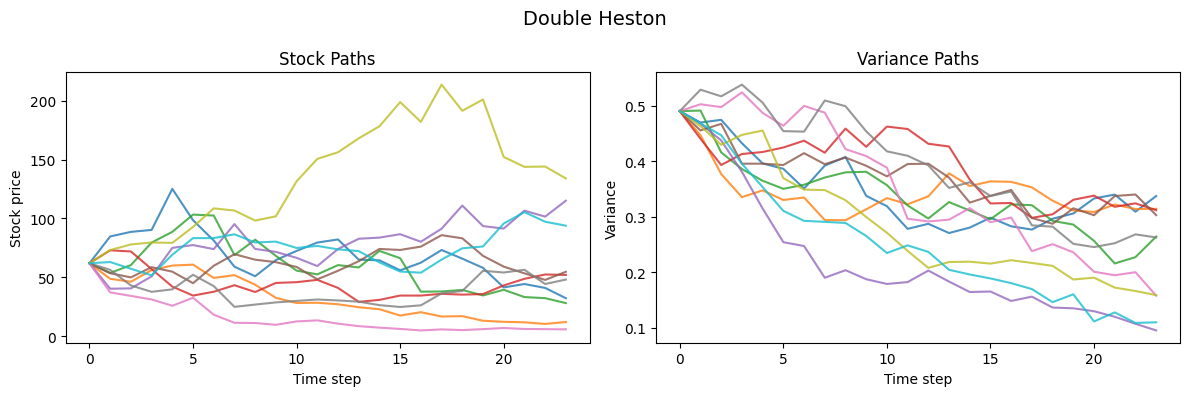

In [17]:
DoubleHeston_test=models.doubleheston.DoubleHeston(r=0.03, q=0.0,
                                                   kappa1=0.9, kappa2=1.2, 
                                                   theta1=0.1, theta2=0.15, 
                                                   sigma1=0.1, sigma2=0.2, 
                                                   rho1=-0.5, rho2=-0.5)

S_double, V1_double, V2_double = DoubleHeston_test.simulate_paths(N_paths=10,N_steps=24, 
                                                                  T=1, S0=61.9, 
                                                                  v01=0.6**2, v02=0.7**2, 
                                                                  seed=20)

plotting.plot_utils.plot_paths(S_double,V2_double, title='Double Heston')

In [18]:
DoubleHeston_test.mc_price(N_paths=100000, N_steps=1000, 
                           K=61.9, T=1, S0=61.9, v01=0.6**2, v02=0.7**2, seed=20)

np.float64(19.43242138500229)

In [19]:
DoubleHeston_test.cf_price(Lphi=0.0000001, Uphi=100, dphi=0.0001, 
                           K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

np.float64(19.45378032050505)

In [20]:
# Compares with cf_price and the value in Rouah's book for delta (0.6730), price call = 19.4538
DoubleHeston_test.price_greeks(Lphi=0.0000001, Uphi=100, dphi=0.0001, 
                               K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

{'call_price': np.float64(19.45378032050505),
 'delta': np.float64(0.6729675032920192)}

In [21]:
hedging_dh=utils.hedging.delta_hedge(model=DoubleHeston_test, model_type='doubleheston', 
                                      K=61.9,N_paths=4, N_steps=200,
                                      T=1, S0=61.9, v01=0.6**2, v02=0.7**2,seed=20)

1.0146643181400137 1.590888496493485


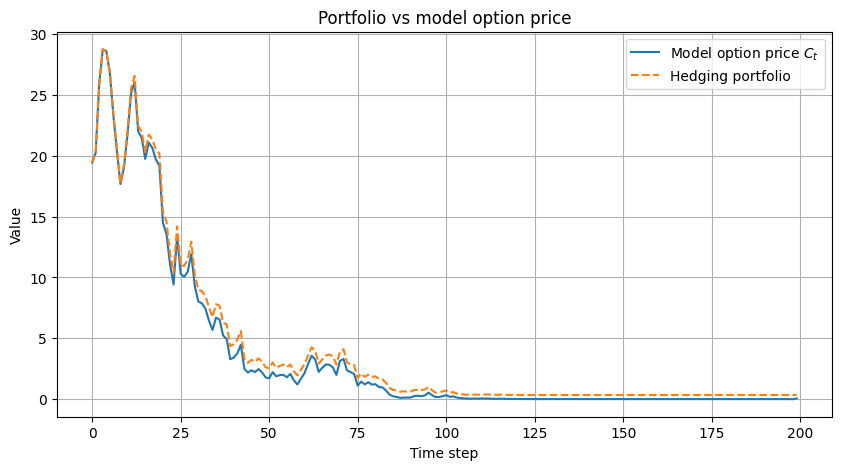

In [22]:
utils.hedging.hedge_plot(hedging_dh["opt_price"][0], hedging_dh["portfolio"][0])

In [23]:
hedging_dh["portfolio"][0], hedging_dh["cash"][0]

(array([19.45366289, 20.30959148, 25.81971226, 28.76676987, 28.63766695,
        26.893584  , 23.4678064 , 20.58281082, 17.75816988, 19.2699297 ,
        22.14542275, 25.53170284, 26.57042723, 22.4614603 , 21.99852103,
        20.29985957, 21.74579642, 21.37256245, 20.49494353, 20.1911307 ,
        15.41941081, 14.59234885, 11.9638382 , 10.39595465, 14.21093355,
        11.01442895, 10.94855681, 11.47968994, 12.94525335, 10.2286723 ,
         8.98927814,  8.8736778 ,  8.48399646,  7.55456758,  6.74214898,
         7.79782846,  7.67935974,  6.27464875,  6.15189307,  4.35430003,
         4.50803393,  4.88585332,  5.59978601,  3.34340624,  2.97489178,
         3.22795519,  3.05394239,  3.34733801,  3.08122279,  2.61972331,
         2.54445879,  3.01023604,  2.58376374,  2.72282184,  2.83879553,
         2.6243657 ,  2.84487689,  2.27346281,  1.94841852,  2.41387404,
         2.87654804,  3.5700779 ,  4.25350899,  3.98840894,  2.91522625,
         3.25364229,  3.57691002,  3.66905657,  3.5

### Monte Carlo Simulations (Double Heston)

#### Brownian motions

Describe how the Brownian motions are simulated.

#### Euler Scheme (Double Heston)

Describe the Euler scheme for the SDEs.

#### Simulations (Double Heston)

In [24]:
#Code goes here
# simulate_paths(S0, v0_1, v0_2, r, kappa1, theta1, sigma1, rho1,kappa2, theta2, sigma2, rho2, rho12, T, N_steps, N_paths)
# mc_price(S_paths, K, r, T, option_type='call')

In [25]:
# Path simulations

### Exact Price (Double Heston)

Formulas go here.

In [26]:
# Code goes here
# dobleheston_cf_price(S0,v0_1, v0_2,r,kappa1, theta1, sigma1, rho1,
# kappa2, theta2, sigma2, rho2,rho12,T, K) # not so sure about the arguments for this one, but we'll find out

In [27]:
# Comparison between Monte Carlo and exact price

## References

Heston, S.L., 1993. A closed-form solution for options with stochastic volatility with applications to bond and currency options. The review of financial studies, 6(2), pp.327-343.

Rouah, F.D., 2013. The Heston model and its extensions in Matlab and C. John Wiley & Sons.